In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import glob
import hvplot.xarray
import panel as pn
import pandas as pd

In [2]:
import xarray as xr

years = list(range(2004, 2024))
months = list(range(1, 13))

file_list = []

for year in years:
    for month in months:
        pattern = f"../data/ocean-data/dataset-uv-rep-monthly_{year}{month:02d}T0000Z_*.nc"
        matches = glob.glob(pattern)
        if matches:
            # Take the first match (or all, depending on your needs)
            file_list.append(matches[0])
        else:
            print(f"No file found for {year}-{month:02d}")

# Optional: sort to ensure consistent order
file_list.sort()

def select_vars(ds):
    return ds[["ugos", "vgos"]]

ds = xr.open_mfdataset(file_list, combine='by_coords', preprocess=select_vars, engine='netcdf4')



In [3]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 240, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2004-01-16T12:00:00 ... 2023-12-16T1...
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    ugos       (time, latitude, longitude) float64 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/17)
    geospatial_lon_units:     degrees_east
    geospatial_vertical_max:  0.0
    product_version:          4.0
    geospatial_lat_units:     degrees_north
    creation_date:            2024-04-23 23:11:59
    contact:                  servicedesk.cmems@mercator-ocean.eu
    ...                       ...
    lon_max:                  179.875
    lon_res:                  0.25
    lat_min:                  -89.875
    lat_max:                  89.875
    lat_res:                  0.25
    title:                    Monthly mean total surface and 15m velocities

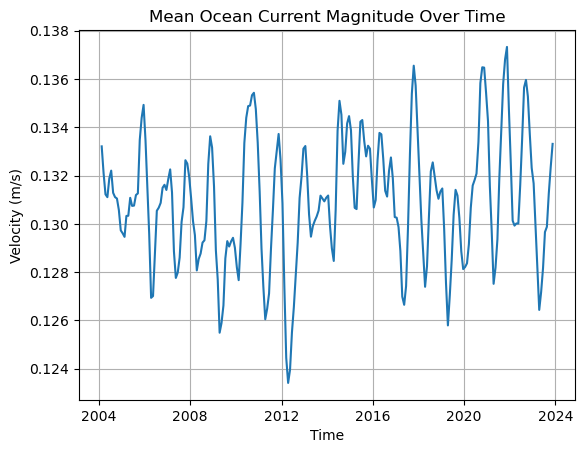

In [4]:
ds["velocity_magnitude"] = (ds["ugos"]**2 + ds["vgos"]**2)**0.5
velocity_time_series = ds["velocity_magnitude"].mean(dim=["longitude", "latitude"])

velocity_time_series.rolling(time=3, center=True).mean().plot()
plt.title("Mean Ocean Current Magnitude Over Time")
plt.ylabel("Velocity (m/s)")  # Adjust if needed
plt.xlabel("Time")
plt.grid(True)
plt.show()


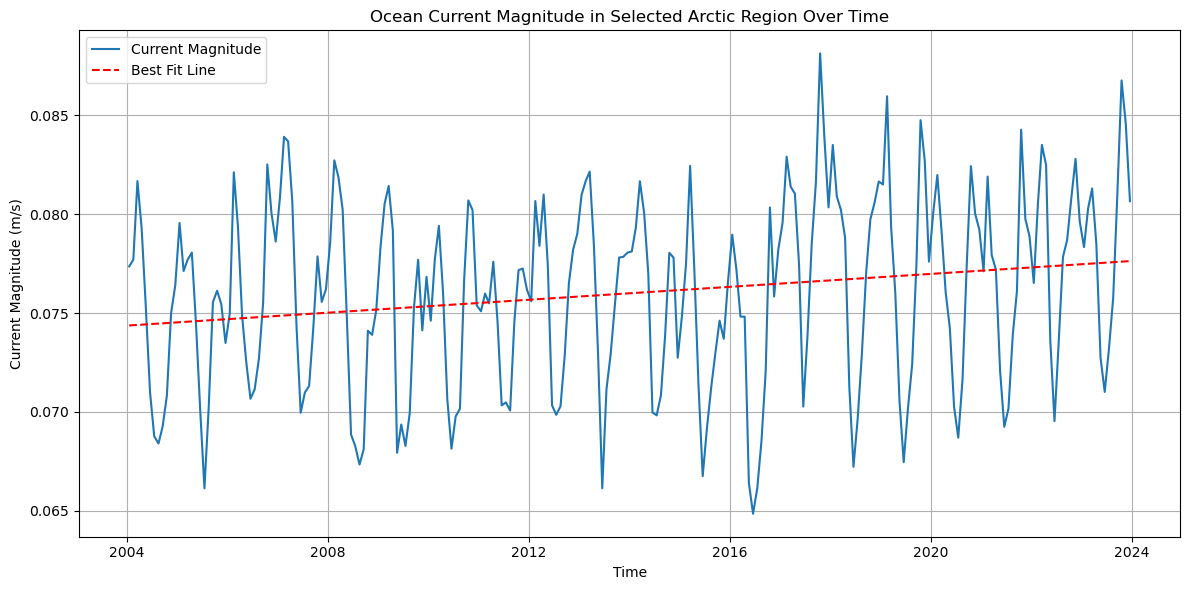

In [5]:
# --- Your original code ---
arctic_ds = ds.sel(
    latitude=slice(59, 83),
    longitude=slice(-73, -12)
)

arctic_ds['current_magnitude'] = np.sqrt(arctic_ds['ugos']**2 + arctic_ds['vgos']**2)
arctic_magnitude_time_series = arctic_ds['current_magnitude'].mean(dim=['latitude', 'longitude'])

# --- Convert time to numeric for regression (days since start) ---
time = arctic_magnitude_time_series['time']
time_numeric = (time - time[0]) / np.timedelta64(1, 'D')
time_numeric = time_numeric.values  # numpy array

# --- Get magnitude values ---
y = arctic_magnitude_time_series.values

# --- Fit a line: y = m*x + b ---
m, b = np.polyfit(time_numeric, y, 1)
trend = m * time_numeric + b

# --- Plot with best fit line ---
plt.figure(figsize=(12,6))
plt.plot(time, y, label='Current Magnitude')
plt.plot(time, trend, color='red', linestyle='--', label='Best Fit Line')
plt.title('Ocean Current Magnitude in Selected Arctic Region Over Time')
plt.xlabel('Time')
plt.ylabel('Current Magnitude (m/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [6]:
pn.extension()

plot = arctic_ds['current_magnitude'].hvplot.quadmesh(
    x='longitude',
    y='latitude',
    geo=True,
    cmap='viridis',
    tiles='ESRI',
    clim=(0, 1),
    frame_width=600,
    groupby='time',
    widget_type='scrubber',
    widget_location='bottom',
)

plot

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=239, width=550)

In [7]:
df = pd.DataFrame({
    'time': pd.to_datetime(time.values),
    'mean_current_magnitude': y,
    'trend_line': trend
})

# Export to CSV
df.to_csv("arctic_current_magnitude_timeseries.csv", index=False)